# How does public transportation accessibility vary across neighbourhoods with different socioeconomic statuses in London?

## Introduction

In today's rapidly urbanizing world, public transport accessibility significantly impacts the urban quality of life. High-quality public transportation offers numerous benefits, such as reduced traffic, lower infrastructure costs, better land use, and improved public health (Litman, T. (2017). Understanding factors affecting accessibility is vital for informed urban planning and policy development.

This project explored the relationships between socio-economic factors and public transport accessibility in London using a comprehensive dataset, including income, education, housing, car ownership, and PTAL scores. We applied four regression models—Linear, Lasso, Random Forest, and Extreme Gradient Boosting—to identify key factors influencing PTAL scores and provide urban planning and policy insights.

## Literature Review

In this part, we review key studies on transport accessibility and urban socio-economics that offer insights into methodologies for examining the relationship between public transport accessibility (measured by PTAL values) and London's neighbourhoods' socio-economic status. Lucas et al. (2016) explored travel behaviours and social disadvantages, using multiple linear regression models, providing a methodological framework for the London context. Paulley et al. (2006) employed PTAL to assess changes in bus service accessibility in Great Britain, demonstrating PTAL's usefulness and applicability in research. Geurs and van Wee (2004) reviewed accessibility measures, emphasizing selecting appropriate indicators. PTAL values will be used in this project as a standardized measure of accessibility in London. These studies provide methodological insights for future research investigating public transportation accessibility disparities across London neighbourhoods, informing policy interventions promoting social equity and sustainable urban development.

## Research Question

What is the relationship between public transportation accessibility, as measured by Public Transport Accessibility Level (PTAL) values, and neighbourhood socioeconomic status in London?

## Presentation of data and data pre-processing

In this project, we collected the Middle Super Output Area (MSOA) 2011 GIS boundary data covering Greater London, MSOA Atlas 2011 data and Transport for London's (TFL) Public Transport Accessibility Levels (PTALs) 2015 data in London DataStore. I will combine these three datasets to examine the relationship between socio-economic factors and public transport accessibility levels (PTALs) in London.

In [1]:
import time
# Set start time of running
start_time = time.time()
print(start_time)

1681353334.5882945


Firstly, we import the libraries we will use and read and load the three datasets

In [2]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import tempfile
import os
import zipfile
import warnings
from shapely.errors import ShapelyDeprecationWarning

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point

# Encoding detection library
import sys
!{sys.executable} -m pip install chardet
import chardet

# Scikit-learn libraries
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Set plotting style
sns.set_style("whitegrid")

# Notebook settings
random_state = 20 # for reproducability
np.random.seed(random_state) # setting numpy random seed, as that is used for sklearn operations

pd.options.display.float_format = '{:40,.4f}'.format # specifies default number form 
plt.style.use('ggplot') # specifies that graphs should use ggplot styling 
%matplotlib inline

In [3]:
# Detect file encoding from URL
def detect_file_encoding_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    result = chardet.detect(response.content)
    return result['encoding']

# Load msoa_atlas file with the detected encoding
msoa_atlas_url = 'https://raw.githubusercontent.com/NoodlesLYU/DSSS_CW/main/data/msoa-data.csv'
encoding = detect_file_encoding_from_url(msoa_atlas_url)
msoa_df  = pd.read_csv(msoa_atlas_url, encoding=encoding)

# Load ptal file from GitHub
ptal_url = 'https://raw.githubusercontent.com/NoodlesLYU/DSSS_CW/main/data/ptal.xlsx'
response = requests.get(ptal_url)
response.raise_for_status()
ptal_df = pd.read_excel(io.BytesIO(response.content))

# Download and extract shapefile
def download_and_extract_shapefile(url, temp_dir):
    response = requests.get(url)
    response.raise_for_status()
    with tempfile.NamedTemporaryFile(suffix='.zip', dir=temp_dir, delete=False) as temp_zip:
        temp_zip.write(response.content)
        temp_zip.flush()
        with zipfile.ZipFile(temp_zip.name, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

def find_shp_file(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.shp') and not file.startswith('._'):
                return os.path.join(root, file)
    raise FileNotFoundError("No .shp file found in the extracted directory")

# Read msoa shapefile from GitHub
def read_shapefile_from_github(url):
    with tempfile.TemporaryDirectory() as temp_dir:
        download_and_extract_shapefile(url, temp_dir)
        shp_file = find_shp_file(temp_dir)
        return gpd.read_file(shp_file)

shapefile_url = 'https://raw.githubusercontent.com/NoodlesLYU/DSSS_CW/main/data/shapefile.zip'
msoa_shapes = read_shapefile_from_github(shapefile_url)

Then we select the columns from the dataset that are relevant to our study and are then renamed to more concise and descriptive names for ease of understanding and manipulation.

Key variables in the MSOA Atlas dataset include:  

- **MSOA_Code**: The unique code assigned to each Middle Super Output Area.  
- **MSOA_Name**: The name of the Middle Super Output Area.  
- **Mean_Annual_Household_Income**: The average annual household income for each MSOA.  
- **Median_Annual_Household_Income**: The median annual household income for each MSOA.  
- **Highest_Level4_Qualifications**: The percentage of the population in each MSOA holding Level 4 qualifications and above.  
- **Social_Rented_Percentage**: The percentage of households in each MSOA living in social rented accommodation.  
- **Private_Rented_Percentage**: The percentage of households in each MSOA living in privately rented accommodation.  
- **No_Car_or_Van_Percentage**: The percentage of households in each MSOA with no car or van.  
- **Cars_per_Household**: The average number of cars per household in each MSOA.  
- **Median_House_Price_2011**: The median house price for each MSOA in 2011.  
- **Unemployment_Rate**: The unemployment rate for each MSOA.  

Key variables in the MSOA boundary dataset include:  

- **MSOA11CD**: The unique code assigned to each Middle Super Output Area.  
- **MSOA11NM**: The name of the Middle Super Output Area.  
- **geometry**: Geographical coordinates information.  

Key variables in the PTAL dataset include:  

- **X**: Latitude.  
- **Y**: longitude.  
- **PTAL2015**: PTAL scores.  

In [4]:
# Define the columns of interest
msoa_atlas_columns = [
    'Middle Super Output Area',
    'MSOA Name',
    'Household Income Estimates (2011/12);Total Mean Annual Household Income (£);',
    'Household Income Estimates (2011/12);Total Median Annual Household Income (£);',
    'Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;',
    'Tenure (2011);Social rented (%);',
    'Tenure (2011);Private rented (%);',
    'Car or van availability (2011 Census);No cars or vans in household (%);',
    'Car or van availability (2011 Census);Cars per household;',
    'House Prices;Median House Price (£);2011',
    'Economic Activity (2011 Census);Unemployment Rate;'
]

# Create a new msoa atlas dataframe
msoa_selected_df = msoa_df[msoa_atlas_columns]

# Rename the columns to more descriptive names
msoa_selected_df = msoa_selected_df.rename(columns={
    'Middle Super Output Area': 'MSOA_Code',
    'MSOA Name': 'MSOA_Name',
    'Household Income Estimates (2011/12);Total Mean Annual Household Income (£);': 'Mean_Annual_Household_Income',
    'Household Income Estimates (2011/12);Total Median Annual Household Income (£);': 'Median_Annual_Household_Income',
    'Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;': 'Highest_Level4_Qualifications',
    'Tenure (2011);Social rented (%);': 'Social_Rented_Percentage',
    'Tenure (2011);Private rented (%);': 'Private_Rented_Percentage',
    'Car or van availability (2011 Census);No cars or vans in household (%);': 'No_Car_or_Van_Percentage',
    'Car or van availability (2011 Census);Cars per household;': 'Cars_per_Household',
    'House Prices;Median House Price (£);2011': 'Median_House_Price_2011',
    'Economic Activity (2011 Census);Unemployment Rate;': 'Unemployment_Rate'
})

# Creat a new msoa boundary dataframe
msoa_selected_shapes = msoa_shapes[['MSOA11CD','MSOA11NM','geometry']]

# Creat a new ptal dataframe
ptal_df = ptal_df[['X','Y','PTAL2015']]

We check the summary of these DataFrames, including the number of non-null values and data types for each column. And then we check for missing values and remove rows from DataFrames that contain missing (NaN) values, and calculate the number of duplicated rows in the DataFrames.

In [5]:
msoa_selected_df.head()

,MSOA_Code,MSOA_Name,Mean_Annual_Household_Income,Median_Annual_Household_Income,Highest_Level4_Qualifications,Social_Rented_Percentage,Private_Rented_Percentage,No_Car_or_Van_Percentage,Cars_per_Household,Median_House_Price_2011,Unemployment_Rate
0,E02000001,City of London 001,59728,46788,4618,16.5000,35.9000,69.4000,0.4000,465000,3.8000
1,E02000002,Barking and Dagenham 001,31788,27059,914,41.8000,9.9000,37.6000,0.8000,185000,11.8000
2,E02000003,Barking and Dagenham 002,43357,36835,1829,11.6000,21.6000,31.2000,1.0000,200000,9.1000
3,E02000004,Barking and Dagenham 003,46701,39668,891,16.0000,9.8000,24.0000,1.1000,193750,9.3000
4,E02000005,Barking and Dagenham 004,34294,29156,1119,24.9000,15.1000,33.9000,0.9000,165000,9.7000


In [6]:
msoa_selected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MSOA_Code                       983 non-null    object 
 1   MSOA_Name                       984 non-null    object 
 2   Mean_Annual_Household_Income    984 non-null    int64  
 3   Median_Annual_Household_Income  984 non-null    int64  
 4   Highest_Level4_Qualifications   984 non-null    int64  
 5   Social_Rented_Percentage        984 non-null    float64
 6   Private_Rented_Percentage       984 non-null    float64
 7   No_Car_or_Van_Percentage        984 non-null    float64
 8   Cars_per_Household              984 non-null    float64
 9   Median_House_Price_2011         984 non-null    int64  
 10  Unemployment_Rate               984 non-null    float64
dtypes: float64(5), int64(4), object(2)
memory usage: 84.7+ KB


In [7]:
msoa_selected_df.isna().sum()

MSOA_Code                         1
MSOA_Name                         0
Mean_Annual_Household_Income      0
Median_Annual_Household_Income    0
Highest_Level4_Qualifications     0
Social_Rented_Percentage          0
Private_Rented_Percentage         0
No_Car_or_Van_Percentage          0
Cars_per_Household                0
Median_House_Price_2011           0
Unemployment_Rate                 0
dtype: int64

In [8]:
msoa_selected_df = msoa_selected_df.dropna()

In [9]:
msoa_selected_df.duplicated().sum()

0

In [10]:
msoa_selected_shapes.head()

,MSOA11CD,MSOA11NM,geometry
0,E02000001,City of London 001,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E02000002,Barking and Dagenham 001,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,"POLYGON ((549102.438 189324.625, 548954.500 18..."
3,E02000004,Barking and Dagenham 003,"POLYGON ((551549.998 187364.637, 551478.000 18..."
4,E02000005,Barking and Dagenham 004,"POLYGON ((549099.634 187656.076, 549161.375 18..."


In [11]:
msoa_selected_shapes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   MSOA11CD  983 non-null    object  
 1   MSOA11NM  983 non-null    object  
 2   geometry  983 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 23.2+ KB


In [12]:
msoa_selected_shapes.isna().sum()

MSOA11CD    0
MSOA11NM    0
geometry    0
dtype: int64

In [13]:
msoa_selected_shapes.duplicated().sum()

0

In [14]:
ptal_df.head()

,X,Y,PTAL2015
0,530870,155930,0
1,530945,155898,0
2,531045,155898,0
3,531145,155898,0
4,531245,155898,0


In [15]:
ptal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159451 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   X         159451 non-null  int64 
 1   Y         159451 non-null  int64 
 2   PTAL2015  159451 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [16]:
ptal_df.isna().sum()

X           0
Y           0
PTAL2015    0
dtype: int64

In [17]:
ptal_df.duplicated().sum()

0

We then merge the msoa atlas and msoa boundary data into one data frame "**merged_df**" and convert it into a geodataframe "**merged_gdf**", and we will use the latitude and longitude data from the "**ptal_df**" to convert it into a geodataframe "**ptal_gdf**" as well, and we merge the two geodataframes into one ("**ptal_msoa_gdf**").

In [18]:
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# Merge two datasets with the same MSOA ID.
merged_df = pd.merge(msoa_selected_df, msoa_selected_shapes, left_on='MSOA_Code', right_on='MSOA11CD')

# Apply a function to each row in the ptal_df DataFrame
ptal_df['geometry'] = ptal_df.apply(
    # Define the lambda function to create a Point object using 'X' and 'Y' coordinates
    lambda row: Point(row['X'], row['Y']),
    # Specify that the function should be applied across rows (axis=1)
    axis=1
)

# Converting two regular pandas DataFrames (ptal_df and merged_df) into GeoDataFrames (ptal_gdf and merged_gdf)
ptal_gdf = gpd.GeoDataFrame(ptal_df, crs='EPSG:4326', geometry='geometry')
merged_gdf = gpd.GeoDataFrame(merged_df, crs='EPSG:4326', geometry='geometry')

In [19]:
# Perform a spatial join between ptal_gdf and merged_gdf
ptal_msoa_gdf = gpd.sjoin(
    ptal_gdf,      # Left GeoDataFrame (public transportation accessibility data)
    merged_gdf,    # Right GeoDataFrame (neighborhood socioeconomic data)
    how='left',    # Type of join (keep all records from the left GeoDataFrame and their corresponding matches from the right GeoDataFrame)
    predicate='within'    # Spatial predicate used for the join (records from the left GeoDataFrame are matched with records from the right GeoDataFrame if their geometries are within the right GeoDataFrame's geometry)
)

PTAL scores are typically classified into nine grades: 0, 1a, 1b, 2, 3, 4, 5, 6a, and 6b. To simplify calculations in this study, we reorganize these grades into nine consecutive scores: 0, 1, 2, 3, 4, 5, 6, 7, and 8. Here, 0 corresponds to the original grade 0, 1 corresponds to the original grade 1a, and so forth. We then use the **MSOA_code** as a consistent identifier and calculate the average of all PTAL scores within each region to represent the final PTAL score for that region. After processing the data, we obtain the final dataframe, "**msoa_with_ptal**".

In [20]:
# Split the PTAL values into nine classes
ptal_scores = {
    '0': 0,
    '1a': 1,
    '1b': 2,
    '2': 3,
    '3': 4,
    '4': 5,
    '5': 6,
    '6a': 7,
    '6b': 8,
}
ptal_msoa_gdf['PTAL_scores'] = ptal_msoa_gdf['PTAL2015'].replace(ptal_scores)

In [21]:
# Group the ptal_msoa_gdf GeoDataFrame by MSOA_Code (neighborhood identifier)
# and calculate the mean of PTAL_scores (public transportation accessibility level) for each group
ptal_msoa_mean = ptal_msoa_gdf.groupby('MSOA_Code')['PTAL_scores'].mean().reset_index()

In [22]:
# Merge the dataset
msoa_with_ptal = merged_gdf.merge(ptal_msoa_mean, on='MSOA_Code', how='left')

In [23]:
# Drop columns that are not necessary for the analysis
msoa_with_ptal = msoa_with_ptal.drop(['MSOA_Name','MSOA11CD','MSOA11NM','geometry'],axis=1)

In [24]:
msoa_with_ptal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MSOA_Code                       983 non-null    object 
 1   Mean_Annual_Household_Income    983 non-null    int64  
 2   Median_Annual_Household_Income  983 non-null    int64  
 3   Highest_Level4_Qualifications   983 non-null    int64  
 4   Social_Rented_Percentage        983 non-null    float64
 5   Private_Rented_Percentage       983 non-null    float64
 6   No_Car_or_Van_Percentage        983 non-null    float64
 7   Cars_per_Household              983 non-null    float64
 8   Median_House_Price_2011         983 non-null    int64  
 9   Unemployment_Rate               983 non-null    float64
 10  PTAL_scores                     983 non-null    float64
dtypes: float64(6), int64(4), object(1)
memory usage: 92.2+ KB


In [25]:
msoa_with_ptal.isna().sum()

MSOA_Code                         0
Mean_Annual_Household_Income      0
Median_Annual_Household_Income    0
Highest_Level4_Qualifications     0
Social_Rented_Percentage          0
Private_Rented_Percentage         0
No_Car_or_Van_Percentage          0
Cars_per_Household                0
Median_House_Price_2011           0
Unemployment_Rate                 0
PTAL_scores                       0
dtype: int64

In [26]:
msoa_with_ptal.duplicated().sum()

0

After merging and simply processing the data frames, we first visualise each data column in individual **histograms** to observe its distribution.

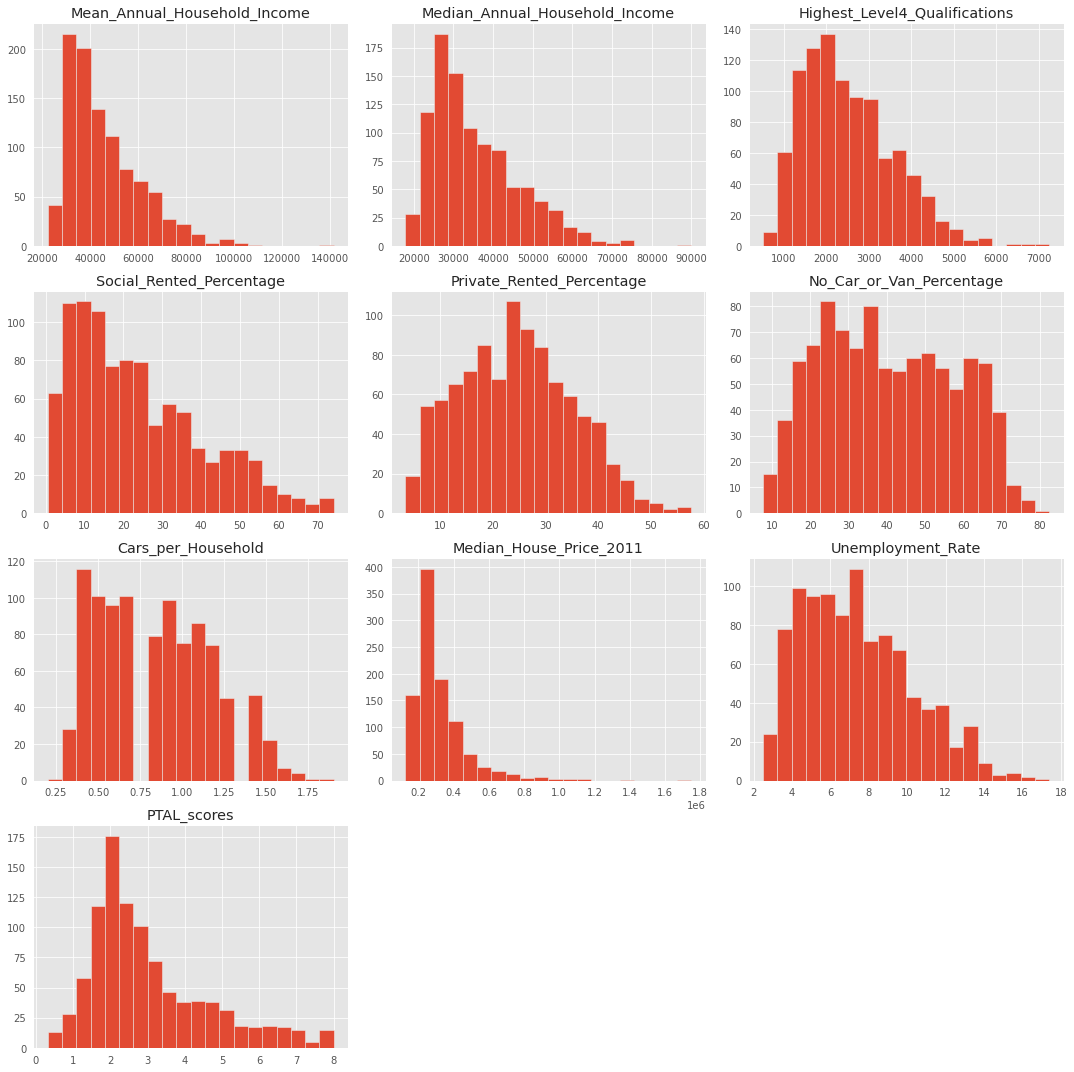

In [27]:
# Create histograms for each numeric column in the msoa_with_ptal GeoDataFrame
msoa_with_ptal.hist(figsize=(15, 15), bins=20)

# Adjust the spacing between subplots to minimize overlaps
plt.tight_layout()

# Display the histograms
plt.show()

We employ **box plots** and the **Interquartile Range (IQR) method** for outlier detection. Box plots help visualize data distribution, making it simpler to spot extreme values. The IQR method concentrates on the data's central 50%, offering a more robust measure of dispersion less influenced by extreme values than mean and standard deviation-based approaches.

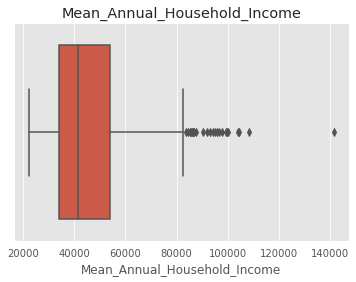

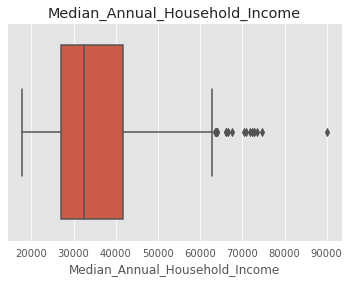

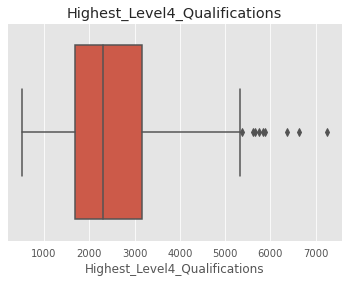

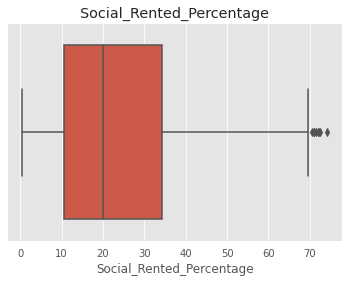

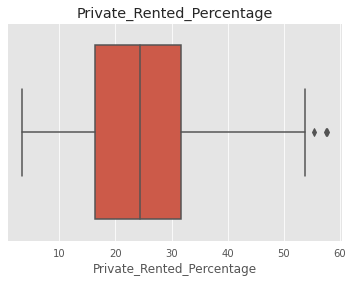

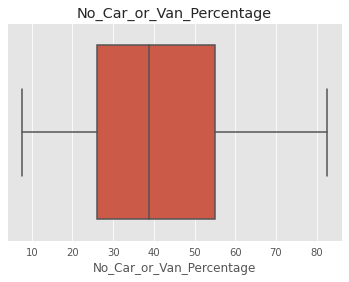

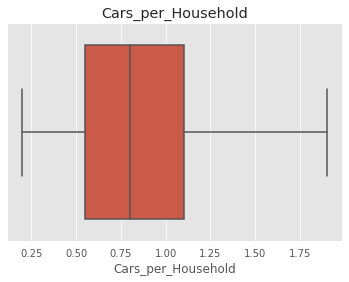

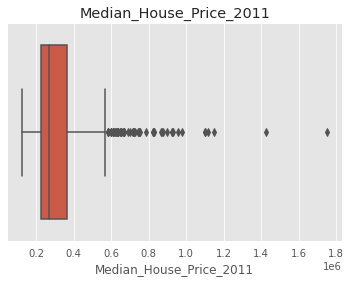

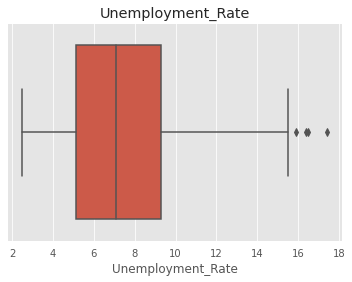

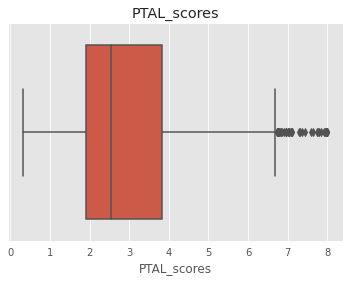

In [28]:
# Create a box plot for each variable
for column in msoa_with_ptal.columns:
    if column != 'MSOA_Code':
        plt.figure()
        sns.boxplot(x=msoa_with_ptal[column])
        plt.title(column)
        plt.show()

In [29]:
# Define a function to detect outliers using the IQR method
def detect_outliers_iqr(dataframe):
    outliers = {}
    for column in dataframe.columns:
        if dataframe[column].dtype != 'object':  # Skip columns with 'object' (string) data type
            Q1 = dataframe[column].quantile(0.25)
            Q3 = dataframe[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[column] = dataframe[column][(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)].index.tolist()
    return outliers

# Detect outliers in the msoa_with_ptal dataframe
outliers = detect_outliers_iqr(msoa_with_ptal)
print(outliers)

{'Mean_Annual_Household_Income': [166, 168, 396, 584, 586, 587, 588, 592, 594, 595, 596, 690, 834, 888, 927, 930, 936, 938, 959, 965, 966, 969, 976, 977], 'Median_Annual_Household_Income': [55, 166, 168, 396, 584, 586, 587, 588, 592, 635, 690, 834, 888, 930, 936, 938, 969, 977], 'Highest_Level4_Qualifications': [256, 364, 370, 631, 807, 889, 929, 931, 947], 'Social_Rented_Percentage': [125, 356, 577, 578, 581, 814, 819, 821], 'Private_Rented_Percentage': [893, 970, 974], 'No_Car_or_Van_Percentage': [], 'Cars_per_Household': [], 'Median_House_Price_2011': [29, 55, 166, 168, 172, 175, 178, 181, 182, 270, 381, 392, 396, 397, 418, 448, 526, 531, 582, 583, 584, 585, 586, 587, 588, 589, 590, 592, 593, 594, 595, 596, 597, 599, 689, 690, 698, 782, 783, 786, 793, 834, 927, 938, 959, 960, 965, 966, 969, 970, 971, 972, 973, 974, 976, 977, 978, 981], 'Unemployment_Rate': [356, 362, 399, 881], 'PTAL_scores': [0, 183, 187, 188, 189, 190, 191, 192, 360, 370, 379, 385, 569, 574, 575, 576, 582, 588, 59

In this project, we retain rows with outliers to prevent significant data loss and preserve valuable information. Outliers represent real-world situations or rare events and removing them may create a biased dataset. Instead, we use the Robust Scaler method, which is less sensitive to outliers. By utilizing median and interquartile spacing (IQR) instead of mean and standard deviation, this scaling method is more robust, making it suitable for datasets where outliers are expected or cannot be confidently removed.

In [30]:
# Create a new DataFrame to store the scaled data
msoa_with_ptal_scaled = msoa_with_ptal.copy()

# Initialize the RobustScaler
scaler = RobustScaler()

# Select the columns to scale (excluding categorical columns)
columns = [col for col in msoa_with_ptal.columns if msoa_with_ptal[col].dtype != 'object']

# Apply the scaler to the selected columns
msoa_with_ptal_scaled[columns] = scaler.fit_transform(msoa_with_ptal[columns])

# Check the transformed DataFrame
msoa_with_ptal_scaled.head()

,MSOA_Code,Mean_Annual_Household_Income,Median_Annual_Household_Income,Highest_Level4_Qualifications,Social_Rented_Percentage,Private_Rented_Percentage,No_Car_or_Van_Percentage,Cars_per_Household,Median_House_Price_2011,Unemployment_Rate,PTAL_scores
0,E02000001,0.9218,0.9835,1.5826,-0.1429,0.7582,1.0517,-0.7273,1.4054,-0.7857,2.8227
1,E02000002,-0.4917,-0.3668,-0.9518,0.9202,-0.9412,-0.0448,0.0000,-0.6126,1.1190,-0.4390
2,E02000003,0.0936,0.3023,-0.3257,-0.3487,-0.1765,-0.2655,0.3636,-0.5045,0.4762,-0.2746
3,E02000004,0.2628,0.4962,-0.9675,-0.1639,-0.9477,-0.5138,0.5455,-0.5495,0.5238,-0.6753
4,E02000005,-0.3649,-0.2233,-0.8115,0.2101,-0.6013,-0.1724,0.1818,-0.7568,0.6190,-0.2644


In [31]:
msoa_with_ptal_scaled.describe()

,Mean_Annual_Household_Income,Median_Annual_Household_Income,Highest_Level4_Qualifications,Social_Rented_Percentage,Private_Rented_Percentage,No_Car_or_Van_Percentage,Cars_per_Household,Median_House_Price_2011,Unemployment_Rate,PTAL_scores
count,983.0000,983.0000,983.0000,983.0000,983.0000,983.0000,983.0000,983.0000,983.0000,983.0000
mean,0.2174,0.2087,0.1423,0.1590,0.0092,0.0548,0.0686,0.3365,0.0666,0.2506
std,0.7795,0.7511,0.7226,0.6956,0.6942,0.5911,0.6110,1.1180,0.6760,0.8391
min,-0.9683,-0.9952,-1.2200,-0.8151,-1.3660,-1.0759,-1.0909,-1.0378,-1.0952,-1.1627
25%,-0.3729,-0.3660,-0.4191,-0.3971,-0.5163,-0.4448,-0.4545,-0.3333,-0.4762,-0.3343
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.6271,0.6340,0.5809,0.6029,0.4837,0.5552,0.5455,0.6667,0.5238,0.6657
max,5.0517,3.9411,3.3787,2.2773,2.1830,1.5034,2.0000,10.6667,2.4524,2.8369


## Methodology

In this literature-informed study, we apply four regression models to our research question:
- Linear Regression: A simple, widely-used technique for modelling relationships between variables (James et al., 2013).
- Lasso Regression: A linear regression variant with regularization, preventing overfitting and aiding feature selection (Zou & Hastie, 2005).
- Random Forest Regression: An ensemble decision tree method that captures complex relationships, handles numerous features, and is robust to multicollinearity (Breiman, 2001).
- Extreme Gradient Boosting Regression: A high-performing, scalable ensemble decision tree method that captures non-linear relationships (Chen & Guestrin, 2016).

We will compare these models using cross-validation and performance metrics (e.g., MSE, R-squared) to determine the best model for our problem. We will also consider interpretability and computational complexity.

We use PTAL_scores as the dependent variable and the remaining data columns as independent variables. The data is divided into training and testing sets for model training and evaluation.

In [32]:
# Prepare the input features (X) and target variable (y)
socioeconomic_factors = ['Mean_Annual_Household_Income', 
                         'Median_Annual_Household_Income',
                         'Highest_Level4_Qualifications',
                         'Social_Rented_Percentage',
                         'Private_Rented_Percentage',
                         'No_Car_or_Van_Percentage',
                         'Cars_per_Household',
                         'Median_House_Price_2011',
                         'Unemployment_Rate'
                        ]

X = msoa_with_ptal_scaled[socioeconomic_factors].values
y = msoa_with_ptal_scaled['PTAL_scores'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Linear Regression

In [33]:
# Create a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the training and testing datasets
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate and print the MSE and R-squared values for both datasets
mse_train_lr = mean_squared_error(y_train, y_train_pred)
mse_test_lr = mean_squared_error(y_test, y_test_pred)
r2_train_lr = r2_score(y_train, y_train_pred)
r2_test_lr = r2_score(y_test, y_test_pred)

print("Training set:")
print(f"MSE: {mse_train_lr}")
print(f"R-squared: {r2_train_lr}")

print("\nTesting set:")
print(f"MSE: {mse_test_lr}")
print(f"R-squared: {r2_test_lr}")

Training set:
MSE: 0.1609539935792723
R-squared: 0.761620507656054

Testing set:
MSE: 0.1907996881276616
R-squared: 0.7503585618945019


### Lasso Regression

In [34]:
# Define the hyperparameter grid for Lasso regression
param_grid_lasso = {
    "alpha": np.logspace(-4, 1, 500)  # Varying alpha (the regularization strength) on a logarithmic scale
}

# Create a Lasso regression model
lasso_model = Lasso()

# Set up the grid search with 5-fold cross-validation
grid_search_lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Fit the GridSearchCV model to the training data
grid_search_lasso.fit(X_train, y_train)

# Get the best hyperparameters
best_params_lasso = grid_search_lasso.best_params_
print("Best hyperparameters:")
print(best_params_lasso)

# Train the best Lasso regression model with the best hyperparameters
best_lasso = grid_search_lasso.best_estimator_
best_lasso.fit(X_train, y_train)

# Make predictions on the training and testing datasets
y_train_pred_lasso = best_lasso.predict(X_train)
y_test_pred_lasso = best_lasso.predict(X_test)

# Calculate and print the MSE and R-squared values for both datasets
mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print("\nTraining set:")
print(f"MSE: {mse_train_lasso}")
print(f"R-squared: {r2_train_lasso}")

print("\nTesting set:")
print(f"MSE: {mse_test_lasso}")
print(f"R-squared: {r2_test_lasso}")

Best hyperparameters:
{'alpha': 0.0001}

Training set:
MSE: 0.1609608768575314
R-squared: 0.7616103132375088

Testing set:
MSE: 0.19081207081147183
R-squared: 0.7503423604477159


### Random Forest Regression

In [35]:
# Define the hyperparameter grid for Random Forest regression
param_grid_rf = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 6, 8, 10]
}

# Create a Random Forest regression model
rf_model = RandomForestRegressor(random_state=random_state)

# Set up the grid search with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV model to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print("Best hyperparameters:")
print(best_params_rf)

# Train the best Random Forest regression model with the best hyperparameters
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train, y_train)

# Make predictions on the training and test datasets
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

# Calculate and print the MSE and R-squared values for both datasets
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print("\nTraining set:")
print("MSE:", mse_train_rf)
print("R-squared:", r2_train_rf)

print("\nTesting set:")
print("MSE:", mse_test_rf)
print("R-squared:", r2_test_rf)

Best hyperparameters:
{'max_depth': 10, 'min_samples_split': 4}

Training set:
MSE: 0.03353254451298785
R-squared: 0.9503369207545017

Testing set:
MSE: 0.19579984145512283
R-squared: 0.7438163841809816


### Extreme Gradient Boosting Regression

In [36]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {           
    'max_depth':[10, 20, 30, 40, 50], 
    'n_estimators':[50, 100, 150, 200, 250]
}

# Create a XGBoost regression model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state)

# Set up the grid search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV model to the training data
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
print("Best hyperparameters:")
print(best_params_xgb)

# Train the best XGBoost regression model with the best hyperparameters
best_xgb = grid_search_xgb.best_estimator_
best_xgb.fit(X_train, y_train)

# Make predictions on the training and test datasets
y_train_pred_xgb = best_xgb.predict(X_train)
y_test_pred_xgb = best_xgb.predict(X_test)

# Calculate and print the MSE and R-squared values for both datasets
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print("\nTraining set:")
print("MSE:", mse_train_xgb)
print("R-squared:", r2_train_xgb)

print("\nTesting set:")
print("MSE:", mse_test_xgb)
print("R-squared:", r2_test_xgb)

Best hyperparameters:
{'max_depth': 30, 'n_estimators': 150}

Training set:
MSE: 3.2071631541323344e-07
R-squared: 0.9999995250059303

Testing set:
MSE: 0.23364864417978143
R-squared: 0.6942951840392229


### Model comparison and selection

In [37]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Lasso Regression', 'Random Forest', 'XGBoost'],
    'MSE Train': [mse_train_lr, mse_train_lasso, mse_train_rf, mse_train_xgb],
    'MSE Test': [mse_test_lr, mse_test_lasso, mse_test_rf, mse_test_xgb],
    'R-squared Train': [r2_train_lr, r2_train_lasso, r2_train_rf, r2_train_xgb],
    'R-squared Test': [r2_test_lr, r2_test_lasso, r2_test_rf, r2_test_xgb]
})

# Calculate the differences between the training and testing metrics
results['MSE Difference'] = abs(results['MSE Train'] - results['MSE Test'])
results['R-squared Difference'] = abs(results['R-squared Train'] - results['R-squared Test'])

# Display the results
results

,Model,MSE Train,MSE Test,R-squared Train,R-squared Test,MSE Difference,R-squared Difference
0,Linear Regression,0.1610,0.1908,0.7616,0.7504,0.0298,0.0113
1,Lasso Regression,0.1610,0.1908,0.7616,0.7503,0.0299,0.0113
2,Random Forest,0.0335,0.1958,0.9503,0.7438,0.1623,0.2065
3,XGBoost,0.0000,0.2336,1.0000,0.6943,0.2336,0.3057


**Linear Regression**:
- MSE Train: 0.1610, MSE Test: 0.1908
- R-squared Train: 0.7616, R-squared Test: 0.7504
- MSE Difference: 0.0298, R-squared Difference: 0.0113

The Linear Regression model performs similarly on both training and testing datasets, with a slightly higher MSE and slightly lower R-squared value on the test dataset, indicating a moderate fit.

**Lasso Regression**:
- MSE Train: 0.1610, MSE Test: 0.1908
- R-squared Train: 0.7616, R-squared Test: 0.7503
- MSE Difference: 0.0299, R-squared Difference: 0.0113

The Lasso Regression model performs similarly to the Linear Regression model, with almost the same values for both training and testing datasets. This suggests that Lasso regularization did not significantly improve the model.

**Random Forest**:
- MSE Train: 0.0335, MSE Test: 0.1958
- R-squared Train: 0.9503, R-squared Test: 0.7438
- MSE Difference: 0.1623, R-squared Difference: 0.2065

The Random Forest model has a low MSE and high R-squared value for the training dataset, but the performance on the testing dataset is not as good. This indicates the model is likely overfitting the training data.

**XGBoost**:
- MSE Train: 0.0000, MSE Test: 0.2336
- R-squared Train: 1.0000, R-squared Test: 0.6943
- MSE Difference: 0.2336, R-squared Difference: 0.3057

The XGBoost model perfectly fits the training data with an MSE of 0 and an R-squared value of 1, but the performance on the testing dataset is significantly worse. This is a strong indication of overfitting.

Linear and Lasso regression models have lower MSEs, and higher R-squared values, and are more interpretable than Random Forest and XGBoost models. Both Random Forest and XGBoost models suffer from overfitting and require more computational resources and time. Considering performance, interpretability, and computational complexity, either Linear or Lasso regression seems to be the best choice for this project.

However, since feature selection is important in this project, Lasso regression is the preferred option, as it can help identify the most relevant features by setting some of the coefficients to zero.

In [38]:
# Retrieve the coefficients from the best Lasso regression model
lasso_coefficients = best_lasso.coef_

# Get the feature names from the scaled dataframe, excluding the first column (index) and the last column (target variable)
feature_names = msoa_with_ptal_scaled.columns[1:-1]

# Create a new DataFrame with the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})

# Calculate the absolute value of the coefficients and add a new column 'Abs_Coefficient' to the DataFrame
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort the DataFrame by the absolute value of the coefficients in descending order
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the sorted DataFrame
coef_df

,Feature,Coefficient,Abs_Coefficient
5,No_Car_or_Van_Percentage,2.1061,2.1061
1,Median_Annual_Household_Income,-0.6369,0.6369
0,Mean_Annual_Household_Income,0.5486,0.5486
3,Social_Rented_Percentage,-0.4962,0.4962
6,Cars_per_Household,0.4404,0.4404
8,Unemployment_Rate,-0.2580,0.2580
4,Private_Rented_Percentage,-0.2070,0.2070
2,Highest_Level4_Qualifications,0.1227,0.1227
7,Median_House_Price_2011,0.0383,0.0383


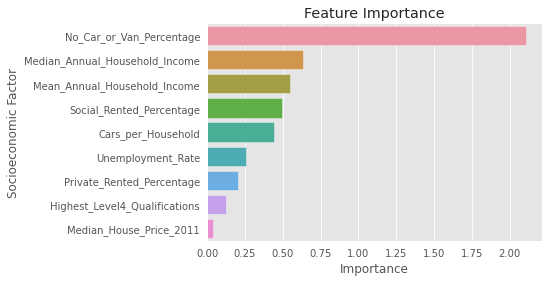

In [39]:
# Create a bar plot using Seaborn
sns.barplot(x='Abs_Coefficient', y='Feature', data=coef_df)

# Set the title for the plot
plt.title('Feature Importance')

# Set the label for the x-axis
plt.xlabel('Importance')

# Set the label for the y-axis
plt.ylabel('Socioeconomic Factor')

# Display the plot
plt.show()

## Results and discussion

This study aimed to predict public transport accessibility levels (PTAL) using socio-economic and demographic variables. Four regression models were evaluated: Linear Regression, Lasso Regression, Random Forest Regression, and Extreme Gradient Boosting Regression, with performance assessed using mean squared error (MSE) and R-squared (R²) metrics. Lasso Regression demonstrated the best balance between performance and interpretability, achieving R-squared values of 0.7616 (training) and 0.7503 (test), and aiding in feature selection.

The most important features contributing to PTAL scores, ordered by their coefficients, are:
- No_Car_or_Van_Percentage (2.1061)
- Median_Annual_Household_Income (-0.6369)
- Mean_Annual_Household_Income (0.5486)
- Social_Rented_Percentage (-0.4962)
- Cars_per_Household (0.4404)
- Unemployment_Rate (-0.2580)
- Private_Rented_Percentage (-0.2070)
- Highest_Level4_Qualifications (0.1227)
- Median_House_Price_2011 (0.0383)

The study found that the key factors in predicting PTAL scores are the percentage of households without a car or van, median and mean annual household incomes, social rented housing percentage, and cars per household. Other significant factors include the unemployment rate, private rented housing percentage, highest Level 4 qualifications, and 2011 median house prices. Higher PTAL scores are associated with more car-free households, lower incomes, lower social-rented housing percentages, and fewer cars per household. Additionally, factors like the unemployment rate, private rented housing percentage, and educational attainment play a role in public transport accessibility. In conclusion, Lasso Regression effectively predicts PTAL scores, offering insights for policymakers and urban planners to improve public transportation infrastructure and services.

### Limitation

Our study offers important insights into socio-economic variables and public transport accessibility levels but has some limitations:

- Data limitations: The analysis depends on the data's accuracy and representativeness, which may not capture all relevant factors or variations within the study area. Data collection and processing errors may also affect the results.
- Model limitations: While Lasso Regression was the best model in this context, other models might perform better with different datasets or contexts. Additionally, the linear relationship assumption may not always hold.
- Generalizability: Our findings are specific to the dataset used, limiting their generalizability to other regions or periods. Relationships between socio-economic factors and public transport accessibility may vary across locations and over time.
- Causal inference: Our study identifies associative relationships, not causality. Further research using experimental or quasi-experimental designs is needed to establish causal relationships.
- Feature selection: Lasso Regression provides an interpretable model with feature selection but may not capture all relevant interactions or non-linear relationships. Future studies could consider alternative feature selection methods like recursive feature elimination or principal component analysis.

Despite these limitations, our study serves as a valuable starting point for understanding factors influencing public transport accessibility levels. Future research can expand on our findings by incorporating additional data sources, exploring alternative modelling techniques, or conducting region- or time-period-specific analyses.

## Conclusion

Our study identified Lasso Regression as the optimal model for analyzing relationships between socio-economic factors and public transport accessibility levels (PTAL). Key factors influencing PTAL scores include the percentage of households without a car or van, median and mean annual household incomes, social rented percentage, and cars per household. These findings can assist urban planners and policymakers in developing targeted strategies to enhance public transport accessibility and address socio-economic disparities.

It is crucial to recognize the study's limitations, such as data quality, model assumptions, generalizability, and causal inference. Further research should explore alternative modelling techniques, additional data sources, and in-depth analyses of specific regions or periods to better comprehend the complex relationships between socio-economic factors and public transport accessibility levels.

In conclusion, our study offers valuable insights into the factors affecting public transport accessibility and emphasizes the importance of considering socio-economic variables in urban planning and policy development. By understanding these relationships, we can contribute to creating more sustainable, equitable, and accessible cities for all residents.

Words count: 1935 words

In [40]:
# Set end time of running
end_time = time.time()
running_time = end_time - start_time
print(f"Total running time is {running_time} seconds")

Total running time is 31.180646181106567 seconds


## Reference 

Breiman, L. (2001). *Random forests*. Machine learning, 45(1), 5-32.

Chen, T., & Guestrin, C. (2016). *Xgboost: A scalable tree boosting system*. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 785-794).

Geurs, K. T., & van Wee, B. (2004). *Accessibility evaluation of land-use and transport strategies: review and research directions*. Journal of Transport Geography, 12(2), 127-140.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). *An Introduction to Statistical Learning* (Vol. 112, pp. 18-24). New York: Springer.

Lucas, K., Bates, J., Moore, J., & Carrasco, J. A. (2016). *Modelling the relationship between travel behaviours and social disadvantage*. Transportation Research Part A: Policy and Practice, 85, 184-198.

Litman, T. (2017). *Evaluating public transit benefits and costs: Best practices guidebook*. Victoria Transport Policy Institute.

Paulley, N., Balcombe, R., Mackett, R., Titheridge, H., Preston, J., Wardman, M., Shires, J., & White, P. (2006). *A PTAL approach to measuring changes in bus service accessibility*. Transport Policy, 13(3), 180-192.

Zou, H., & Hastie, T. (2005). *Regularization and variable selection via the elastic net*. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 67(2), 301-320.